# Phân tích cổ phiếu FPT - Bài tập 1: Hiểu dữ liệu

## Môn: Khai phá và Phân tích Dữ liệu

**Nhóm thực hiện:**
- Nguyễn Đức Minh (MSSV: 24022404)
- Dương Lý Khánh Hạ (MSSV: 23020362)

---

Báo cáo này thực hiện phân tích dữ liệu lịch sử giá cổ phiếu và các chỉ số tài chính của FPT, tập trung vào việc tổng hợp, trực quan hóa, phân tích tương quan và rút ra các insights đầu tư dựa trên dữ liệu thực tế.

## 0. Setup và Import Libraries

In [34]:
# Import thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import warnings
from datetime import datetime, timedelta

# Cấu hình
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.unicode_minus'] = False
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

print('✅ Libraries imported successfully!')
print('Python version:', pd.__version__)

✅ Libraries imported successfully!
Python version: 2.2.3


## 1. Đọc và Quan sát Dữ liệu

In [35]:
# Đường dẫn file - THAY ĐỔI CHO PHÙ HỢP VỚI MÁY CỦA BẠN
price_path = r'C:\Users\ducmi\OneDrive\Desktop\Combo\(None)KhaiPhaVaPhanTichDuLieu\Bài tập lập trình 1\Data sets\Simplize_FPT_PriceHistory_20250315.xlsx'
financial_path = r'C:\Users\ducmi\OneDrive\Desktop\Combo\(None)KhaiPhaVaPhanTichDuLieu\Bài tập lập trình 1\Data sets\Simplize_FPT_FinancialIndicator_20250315.xlsx'

# Đọc dữ liệu
try:
    price = pd.read_excel(price_path, skiprows=5)
    financial_raw = pd.read_excel(financial_path, skiprows=6)
    print('✅ Đọc dữ liệu thành công!')
    print(f'Price data shape: {price.shape}')
    print(f'Financial data shape: {financial_raw.shape}')
except FileNotFoundError:
    print('❌ Không tìm thấy file. Vui lòng kiểm tra lại đường dẫn!')
    # Sử dụng đường dẫn mặc định nếu có
    price_path = 'Simplize_FPT_PriceHistory_20250315.xlsx'
    financial_path = 'Simplize_FPT_FinancialIndicator_20250315.xlsx'
    price = pd.read_excel(price_path, skiprows=5)
    financial_raw = pd.read_excel(financial_path, skiprows=6)

✅ Đọc dữ liệu thành công!
Price data shape: (1007, 8)
Financial data shape: (69, 41)


In [36]:
# Kiểm tra và sửa tên cột nếu cần
print('Columns in price data:', price.columns.tolist())
print('\nColumns in financial data (first 5):', financial_raw.columns.tolist()[:5])

# Rename columns cho dễ xử lý (nếu cột tiếng Việt bị lỗi encoding)
if 'NGÀY' in price.columns:
    price_cols = ['NGÀY', 'GIÁ MỞ CỬA', 'GIÁ CAO NHẤT', 'GIÁ THẤP NHẤT', 
                  'GIÁ ĐÓNG CỬA', 'THAY ĐỔI GIÁ', '% THAY ĐỔI', 'KHỐI LƯỢNG']
else:
    # Nếu tên cột bị lỗi, rename theo thứ tự
    price.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Change', 'ChangePercent', 'Volume']
    price_cols = price.columns.tolist()

print('\nColumns after processing:', price.columns.tolist())

Columns in price data: ['NGÀY', 'GIÁ MỞ CỬA', 'GIÁ CAO NHẤT', 'GIÁ THẤP NHẤT', 'GIÁ ĐÓNG CỬA', 'THAY ĐỔI GIÁ', '% THAY ĐỔI', 'KHỐI LƯỢNG']

Columns in financial data (first 5): ['CHỈ TIÊU', 'Q4/2024', 'Q3/2024', 'Q2/2024', 'Q1/2024']

Columns after processing: ['NGÀY', 'GIÁ MỞ CỬA', 'GIÁ CAO NHẤT', 'GIÁ THẤP NHẤT', 'GIÁ ĐÓNG CỬA', 'THAY ĐỔI GIÁ', '% THAY ĐỔI', 'KHỐI LƯỢNG']


### 1.1 Thống kê mô tả - Price History

In [37]:
# Xử lý dữ liệu ngày tháng
date_col = price.columns[0]  # Cột đầu tiên là ngày
price[date_col] = pd.to_datetime(price[date_col], format='%d/%m/%Y', errors='coerce')
price = price.dropna(subset=[date_col])
price = price.sort_values(date_col)
price.reset_index(drop=True, inplace=True)

# Đặt tên chuẩn cho các cột
price.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Change', 'ChangePercent', 'Volume']

print('='*70)
print('THỐNG KÊ MÔ TẢ - BẢNG PRICE HISTORY')
print('='*70)
print(f'Dữ liệu từ: {price["Date"].min().strftime("%d/%m/%Y")} đến {price["Date"].max().strftime("%d/%m/%Y")}')
print(f'Tổng số ngày giao dịch: {len(price)}')

# Five-number summary và thống kê khác
stats_cols = ['Close', 'Change', 'ChangePercent', 'Volume']
price_stats = price[stats_cols].describe()

# Thêm các metrics khác
price_stats.loc['variance'] = price[stats_cols].var()
price_stats.loc['median'] = price[stats_cols].median()
price_stats.loc['skew'] = price[stats_cols].skew()
price_stats.loc['kurtosis'] = price[stats_cols].kurtosis()
price_stats.loc['CV%'] = (price[stats_cols].std() / price[stats_cols].mean()) * 100

print('\n', price_stats.round(2))

THỐNG KÊ MÔ TẢ - BẢNG PRICE HISTORY
Dữ liệu từ: 15/03/2021 đến 14/03/2025
Tổng số ngày giao dịch: 1000

                  Close     Change  ChangePercent           Volume
count          1000.00     547.00         547.00          1000.00
mean          78715.40     163.44           0.00       3058940.67
std           32045.58    1627.27           0.01       2184421.12
min           38548.07   -7900.00          -0.05        221000.00
25%           56368.36    -600.00          -0.01       1538375.00
50%           62028.03     100.00           0.00       2553581.00
75%           95584.50     900.00           0.01       3851300.00
max          154300.00    7800.00           0.07      16094000.00
variance 1026919022.51 2648001.35           0.00 4771695639296.23
median        62028.03     100.00           0.00       2553581.00
skew              1.01       0.23           0.44             1.91
kurtosis         -0.42       3.20           2.43             5.31
CV%              40.71     995.66    

### 1.2 Thống kê mô tả - Financial Indicator

In [38]:
print('\n' + '='*70)
print('THỐNG KÊ MÔ TẢ - BẢNG FINANCIAL INDICATOR')
print('='*70)
print(f'Shape: {financial_raw.shape}')

# Đếm số quý có dữ liệu
quarters = [col for col in financial_raw.columns if 'Q' in str(col) and '/' in str(col)]
print(f'Số quý có dữ liệu: {len(quarters)}')
print(f'Số chỉ tiêu tài chính: {len(financial_raw)}')

if len(quarters) > 0:
    print(f'Thời gian: {quarters[-1]} đến {quarters[0]}')
    
# Hiển thị một số chỉ tiêu quan trọng
print('\nMột số chỉ tiêu tài chính có trong dữ liệu:')
metric_col = financial_raw.columns[0]  # Cột đầu tiên chứa tên chỉ tiêu
important_metrics = ['P/E', 'ROE', 'ROA', 'EPS', 'Biên lợi nhuận']
for metric in important_metrics:
    matching = financial_raw[metric_col].apply(lambda x: metric in str(x) if pd.notna(x) else False)
    if matching.any():
        print(f'  ✓ {metric}')


THỐNG KÊ MÔ TẢ - BẢNG FINANCIAL INDICATOR
Shape: (69, 41)
Số quý có dữ liệu: 40
Số chỉ tiêu tài chính: 69
Thời gian: Q1/2015 đến Q4/2024

Một số chỉ tiêu tài chính có trong dữ liệu:
  ✓ P/E
  ✓ ROE
  ✓ ROA
  ✓ EPS
  ✓ Biên lợi nhuận


### 1.3 Visualization - Biến động giá cổ phiếu

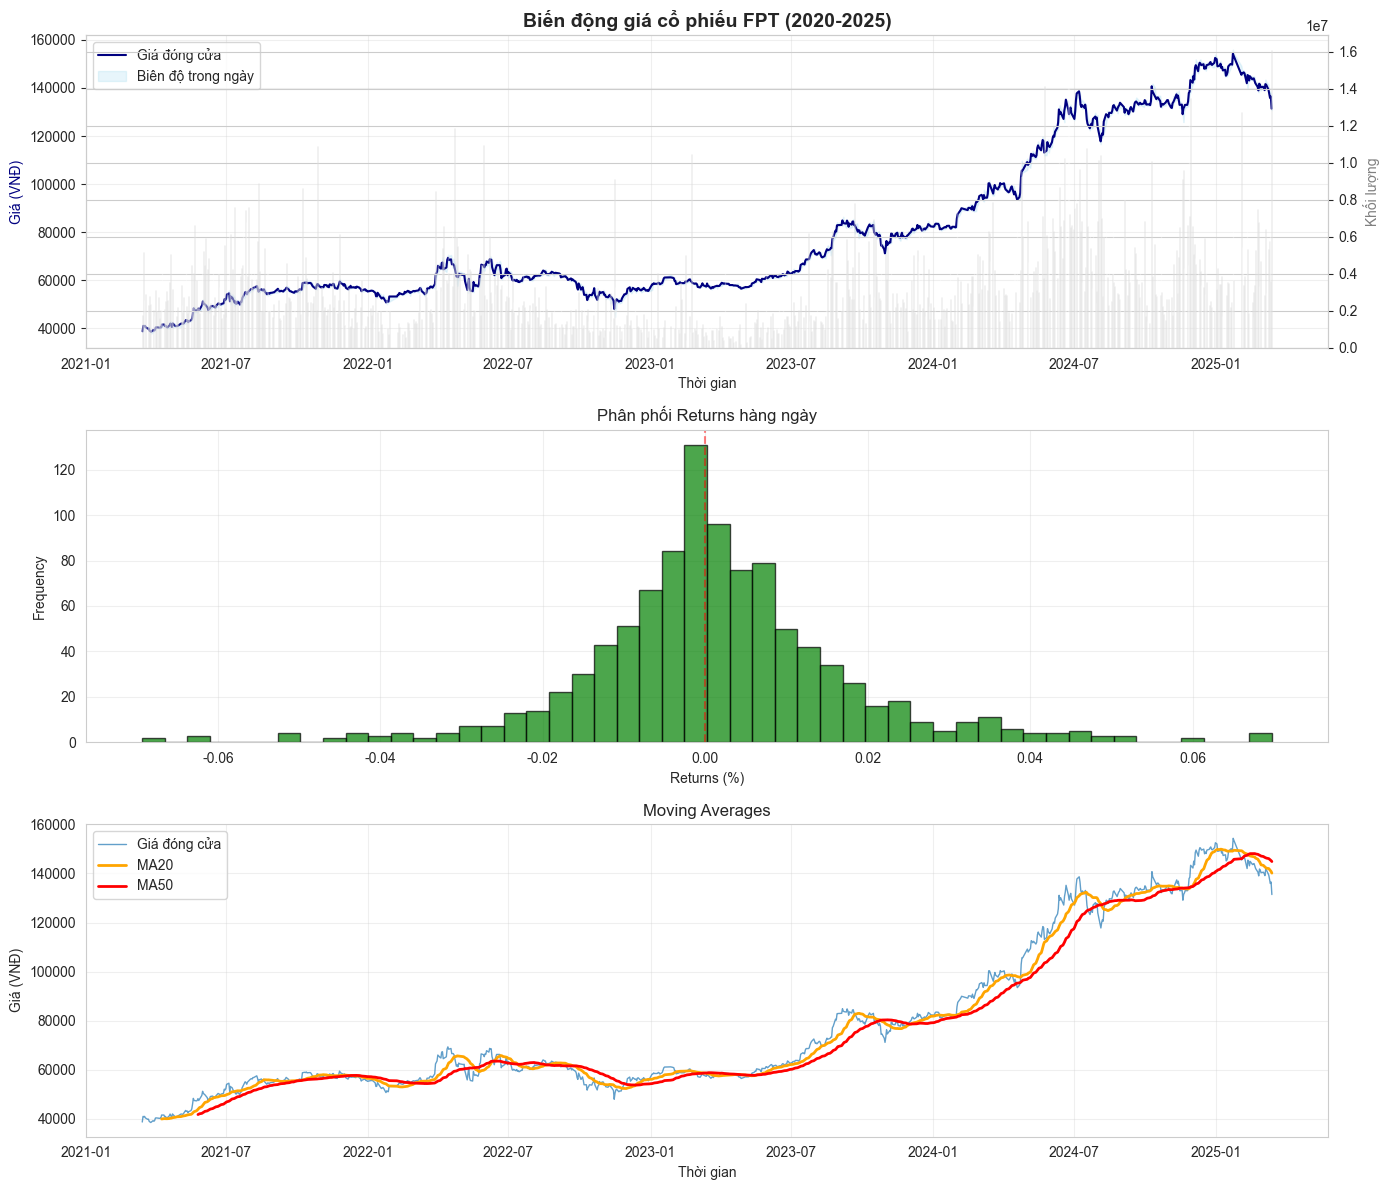


📊 THÔNG TIN TỔNG QUAN:
Giá cao nhất: 154,300 VNĐ
Giá thấp nhất: 38,548 VNĐ
Biên độ dao động: 115,752 VNĐ
Khối lượng TB: 3,058,941
Volatility (std of returns): 0.0164


In [39]:
# Tạo figure với nhiều subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Biểu đồ giá và volume
ax1 = axes[0]
ax2 = ax1.twinx()

# Plot giá
ax1.plot(price['Date'], price['Close'], linewidth=1.5, color='navy', label='Giá đóng cửa')
ax1.fill_between(price['Date'], price['Low'], price['High'], 
                  alpha=0.2, color='skyblue', label='Biên độ trong ngày')

# Plot volume
ax2.bar(price['Date'], price['Volume'], alpha=0.3, color='gray', width=0.8)

ax1.set_xlabel('Thời gian')
ax1.set_ylabel('Giá (VNĐ)', color='navy')
ax2.set_ylabel('Khối lượng', color='gray')
ax1.set_title('Biến động giá cổ phiếu FPT (2020-2025)', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# 2. Returns distribution
price['Returns'] = price['Close'].pct_change()
axes[1].hist(price['Returns'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Returns (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Phân phối Returns hàng ngày')
axes[1].grid(True, alpha=0.3)

# 3. Moving averages
price['MA20'] = price['Close'].rolling(window=20).mean()
price['MA50'] = price['Close'].rolling(window=50).mean()

axes[2].plot(price['Date'], price['Close'], linewidth=1, alpha=0.7, label='Giá đóng cửa')
axes[2].plot(price['Date'], price['MA20'], linewidth=2, color='orange', label='MA20')
axes[2].plot(price['Date'], price['MA50'], linewidth=2, color='red', label='MA50')
axes[2].set_xlabel('Thời gian')
axes[2].set_ylabel('Giá (VNĐ)')
axes[2].set_title('Moving Averages')
axes[2].legend(loc='best')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In thông tin tổng quan
print(f"\n📊 THÔNG TIN TỔNG QUAN:")
print(f"Giá cao nhất: {price['Close'].max():,.0f} VNĐ")
print(f"Giá thấp nhất: {price['Close'].min():,.0f} VNĐ")
print(f"Biên độ dao động: {price['Close'].max() - price['Close'].min():,.0f} VNĐ")
print(f"Khối lượng TB: {price['Volume'].mean():,.0f}")
print(f"Volatility (std of returns): {price['Returns'].std():.4f}")

## 2. Tiền xử lý dữ liệu - Tạo bảng theo quý

In [40]:
# Định nghĩa các quý cần phân tích
quarter_ends = [
    ('Q1/2021', '2021-03-31'), ('Q2/2021', '2021-06-30'),
    ('Q3/2021', '2021-09-30'), ('Q4/2021', '2021-12-31'),
    ('Q1/2022', '2022-03-31'), ('Q2/2022', '2022-06-30'),
    ('Q3/2022', '2022-09-30'), ('Q4/2022', '2022-12-31'),
    ('Q1/2023', '2023-03-31'), ('Q2/2023', '2023-06-30'),
    ('Q3/2023', '2023-09-30'), ('Q4/2023', '2023-12-31'),
    ('Q1/2024', '2024-03-31'), ('Q2/2024', '2024-06-30'),
    ('Q3/2024', '2024-09-30'), ('Q4/2024', '2024-12-31')
]

# Tính giá trung bình theo quý (±14 ngày)
quarterly_prices = []

for quarter, end_date in quarter_ends:
    end = pd.to_datetime(end_date)
    start = end - pd.Timedelta(days=14)
    finish = end + pd.Timedelta(days=14)
    
    # Lọc dữ liệu trong khoảng ±14 ngày
    mask = (price['Date'] >= start) & (price['Date'] <= finish)
    q_data = price[mask]
    
    if not q_data.empty:
        quarterly_prices.append({
            'Quy': quarter,
            'Gia_dong_cua_TB': q_data['Close'].mean(),
            'KLGD_TB': q_data['Volume'].mean(),
            'Volatility': q_data['Close'].std(),
            'High_Q': q_data['Close'].max(),
            'Low_Q': q_data['Close'].min(),
            'Trading_days': len(q_data)
        })

df_price = pd.DataFrame(quarterly_prices)

# Tính các chỉ số thay đổi
df_price['Thay_doi_gia'] = df_price['Gia_dong_cua_TB'].diff()
df_price['Pct_thay_doi'] = df_price['Gia_dong_cua_TB'].pct_change() * 100

print('Dữ liệu giá theo quý (5 dòng đầu):')
print(df_price.head())
print(f'\nTổng số quý: {len(df_price)}')

Dữ liệu giá theo quý (5 dòng đầu):
       Quy  Gia_dong_cua_TB    KLGD_TB  Volatility   High_Q    Low_Q  \
0  Q1/2021         40156.96 2510579.05      879.68 41587.34 38548.07   
1  Q2/2021         51186.02 3446246.76     1659.65 54557.50 48613.27   
2  Q3/2021         56491.78 2920128.00     1477.44 59123.06 54781.02   
3  Q4/2021         55527.50 1816588.80     1067.06 57338.66 53234.55   
4  Q1/2022         62114.90 3723836.25     4719.42 69353.61 54721.54   

   Trading_days  Thay_doi_gia  Pct_thay_doi  
0            21           NaN           NaN  
1            21      11029.07         27.46  
2            21       5305.76         10.37  
3            20       -964.28         -1.71  
4            20       6587.40         11.86  

Tổng số quý: 16


In [41]:
# Xử lý dữ liệu financial indicator
# Các chỉ tiêu cần lấy
metrics_map = {
    'Biên lợi nhuận gộp': 'Bien_LN_gop',
    'Biên lợi nhuận ròng': 'Bien_LN_rong',
    'P/E': 'PE',
    'EPS': 'EPS',
    'Tăng trưởng EPS': 'Tang_truong_EPS',
    'ROE': 'ROE',
    'ROA': 'ROA',
    'Nợ phải trả/Vốn chủ sở hữu': 'No_Von_CSH',
    'Khả năng thanh toán tổng quát': 'Thanh_toan_TQ',
    'Vòng quay tài sản': 'Vong_quay_TS',
    'Giá trị sổ sách': 'Gia_tri_so_sach'
}

# Extract financial data
financial_data = []
quarters = [col for col in financial_raw.columns if 'Q' in str(col) and '/' in str(col)]

# Lấy 16 quý gần nhất
for quarter in quarters[:16]:
    q_dict = {'Quy': quarter}
    
    # Duyệt qua các chỉ tiêu
    for idx, metric in enumerate(financial_raw.iloc[:, 0]):
        if pd.notna(metric):
            metric_str = str(metric).strip()
            
            # Tìm và lấy giá trị cho các metrics
            for key, col_name in metrics_map.items():
                if key in metric_str:
                    try:
                        val = financial_raw.loc[idx, quarter]
                        q_dict[col_name] = float(val) if pd.notna(val) else np.nan
                    except:
                        q_dict[col_name] = np.nan
                    break
    
    financial_data.append(q_dict)

df_financial = pd.DataFrame(financial_data)

print('\nDữ liệu financial indicators (5 dòng đầu):')
print(df_financial.head())
print(f'\nSố chỉ tiêu đã extract: {len(df_financial.columns) - 1}')


Dữ liệu financial indicators (5 dòng đầu):
       Quy    PE  EPS  Gia_tri_so_sach  Bien_LN_gop  Bien_LN_rong  ROE  ROA  \
0  Q4/2024 26.89 0.04         20300.16         0.37          0.14 0.29 0.14   
1  Q3/2024 27.02 0.04         20184.50         0.39          0.16 0.28 0.14   
2  Q2/2024 24.72 0.08         18820.48         0.37          0.15 0.28 0.14   
3  Q1/2024 20.59 0.05         18374.07         0.39          0.15 0.28 0.14   
4  Q4/2023 19.32 0.10         19677.77         0.38          0.14 0.28 0.14   

   Vong_quay_TS  Thanh_toan_TQ  
0          0.25           1.99  
1          0.24           2.10  
2          0.24           2.01  
3          0.23           2.05  
4          0.24           1.99  

Số chỉ tiêu đã extract: 9


In [42]:
# Merge dữ liệu giá và financial
df_merged = pd.merge(df_price, df_financial, on='Quy', how='inner')

print('='*70)
print('BẢNG DỮ LIỆU MỚI SAU KHI MERGE (5 dòng đầu):')
print('='*70)
print(df_merged.head())
print(f"\nShape: {df_merged.shape}")
print(f"Số quý có đầy đủ dữ liệu: {len(df_merged)}")
print(f"Số features: {len(df_merged.columns)}")

BẢNG DỮ LIỆU MỚI SAU KHI MERGE (5 dòng đầu):
       Quy  Gia_dong_cua_TB    KLGD_TB  Volatility   High_Q    Low_Q  \
0  Q1/2021         40156.96 2510579.05      879.68 41587.34 38548.07   
1  Q2/2021         51186.02 3446246.76     1659.65 54557.50 48613.27   
2  Q3/2021         56491.78 2920128.00     1477.44 59123.06 54781.02   
3  Q4/2021         55527.50 1816588.80     1067.06 57338.66 53234.55   
4  Q1/2022         62114.90 3723836.25     4719.42 69353.61 54721.54   

   Trading_days  Thay_doi_gia  Pct_thay_doi    PE   EPS  Gia_tri_so_sach  \
0            21           NaN           NaN 16.53  0.05         18334.38   
1            21      11029.07         27.46 18.29 -0.02         18498.56   
2            21       5305.76         10.37 22.06  0.05         18713.57   
3            20       -964.28         -1.71 21.79  0.15         19770.51   
4            20       6587.40         11.86 19.31  0.13         17487.07   

   Bien_LN_gop  Bien_LN_rong  ROE  ROA  Vong_quay_TS  Thanh_toan_

## 3. Phân tích tương quan với giá cổ phiếu

In [43]:
# Tính ma trận tương quan
numeric_cols = df_merged.select_dtypes(include=[np.number]).columns
corr_matrix = df_merged[numeric_cols].corr()

# Lấy tương quan với giá
price_corr = corr_matrix['Gia_dong_cua_TB'].sort_values(ascending=False)

print('='*70)
print('TƯƠNG QUAN PEARSON VỚI GIÁ CỔ PHIẾU')
print('='*70)

for factor, corr in price_corr.items():
    if factor != 'Gia_dong_cua_TB' and not pd.isna(corr):
        # Xác định mức ý nghĩa
        if abs(corr) > 0.7:
            sig = '***'
        elif abs(corr) > 0.5:
            sig = '**'
        elif abs(corr) > 0.3:
            sig = '*'
        else:
            sig = ''
        
        # Xác định hướng tương quan
        direction = '↑' if corr > 0 else '↓'
        
        print(f"{factor:25} {corr:>8.4f} {sig:3} {direction}")

print("\nGhi chú: *** |r|>0.7 (Mạnh), ** |r|>0.5 (TB-Mạnh), * |r|>0.3 (TB)")
print("        ↑ Tương quan thuận, ↓ Tương quan nghịch")

TƯƠNG QUAN PEARSON VỚI GIÁ CỔ PHIẾU
Low_Q                       0.9988 *** ↑
High_Q                      0.9987 *** ↑
PE                          0.8226 *** ↑
ROA                         0.8218 *** ↑
Vong_quay_TS                0.6892 **  ↑
ROE                         0.6082 **  ↑
KLGD_TB                     0.5949 **  ↑
Thanh_toan_TQ               0.5925 **  ↑
Thay_doi_gia                0.5849 **  ↑
Gia_tri_so_sach             0.5797 **  ↑
Pct_thay_doi                0.3155 *   ↑
Volatility                  0.2129     ↑
EPS                         0.0906     ↑
Bien_LN_rong               -0.0361     ↓
Trading_days               -0.2286     ↓
Bien_LN_gop                -0.3785 *   ↓

Ghi chú: *** |r|>0.7 (Mạnh), ** |r|>0.5 (TB-Mạnh), * |r|>0.3 (TB)
        ↑ Tương quan thuận, ↓ Tương quan nghịch


In [44]:
# Kiểm định ý nghĩa thống kê
from scipy.stats import pearsonr

print('\n' + '='*70)
print('KIỂM ĐỊNH Ý NGHĨA THỐNG KÊ CỦA TƯƠNG QUAN')
print('='*70)

significant_factors = []

for col in numeric_cols:
    if col != 'Gia_dong_cua_TB' and col in df_merged.columns:
        # Loại bỏ NaN
        valid_data = df_merged[['Gia_dong_cua_TB', col]].dropna()
        
        if len(valid_data) > 3:  # Cần ít nhất 4 điểm dữ liệu
            corr, p_value = pearsonr(valid_data['Gia_dong_cua_TB'], valid_data[col])
            
            # Chỉ in các tương quan có ý nghĩa thống kê (p < 0.05)
            if p_value < 0.05:
                significant_factors.append((col, corr, p_value))
                print(f"{col:25} r={corr:>7.4f}, p={p_value:.6f} {'✓' if p_value < 0.01 else ''}")

print(f"\nTổng số yếu tố có ý nghĩa thống kê (p<0.05): {len(significant_factors)}")


KIỂM ĐỊNH Ý NGHĨA THỐNG KÊ CỦA TƯƠNG QUAN
KLGD_TB                   r= 0.5949, p=0.015061 
High_Q                    r= 0.9987, p=0.000000 ✓
Low_Q                     r= 0.9988, p=0.000000 ✓
Thay_doi_gia              r= 0.5849, p=0.022010 
PE                        r= 0.8226, p=0.000091 ✓
Gia_tri_so_sach           r= 0.5797, p=0.018592 
ROE                       r= 0.6082, p=0.012438 
ROA                       r= 0.8218, p=0.000094 ✓
Vong_quay_TS              r= 0.6892, p=0.003144 ✓
Thanh_toan_TQ             r= 0.5925, p=0.015574 

Tổng số yếu tố có ý nghĩa thống kê (p<0.05): 10


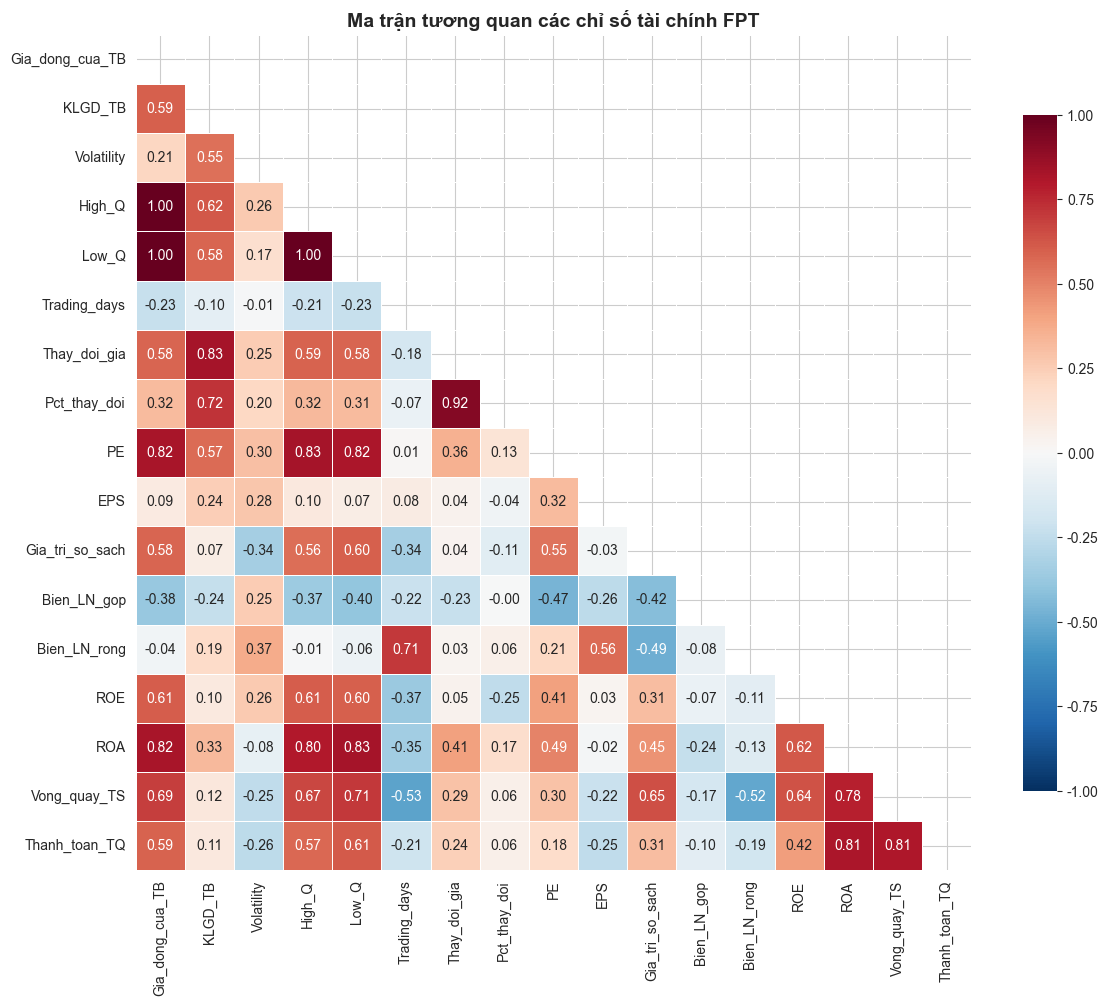

In [45]:
# Visualize correlation matrix
plt.figure(figsize=(12, 10))

# Tạo mask cho tam giác trên
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Vẽ heatmap
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt='.2f', 
            cmap='RdBu_r',
            center=0,
            mask=mask,
            vmin=-1, 
            vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8})

plt.title('Ma trận tương quan các chỉ số tài chính FPT', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

CÁC YẾU TỐ CÓ TƯƠNG QUAN MẠNH (|r| > 0.5)
Low_Q                       0.9988  (Tương quan thuận, Mạnh)
High_Q                      0.9987  (Tương quan thuận, Mạnh)
PE                          0.8226  (Tương quan thuận, Mạnh)
ROA                         0.8218  (Tương quan thuận, Mạnh)
Vong_quay_TS                0.6892  (Tương quan thuận, Trung bình - Mạnh)
ROE                         0.6082  (Tương quan thuận, Trung bình - Mạnh)
KLGD_TB                     0.5949  (Tương quan thuận, Trung bình - Mạnh)
Thanh_toan_TQ               0.5925  (Tương quan thuận, Trung bình - Mạnh)
Thay_doi_gia                0.5849  (Tương quan thuận, Trung bình - Mạnh)
Gia_tri_so_sach             0.5797  (Tương quan thuận, Trung bình - Mạnh)


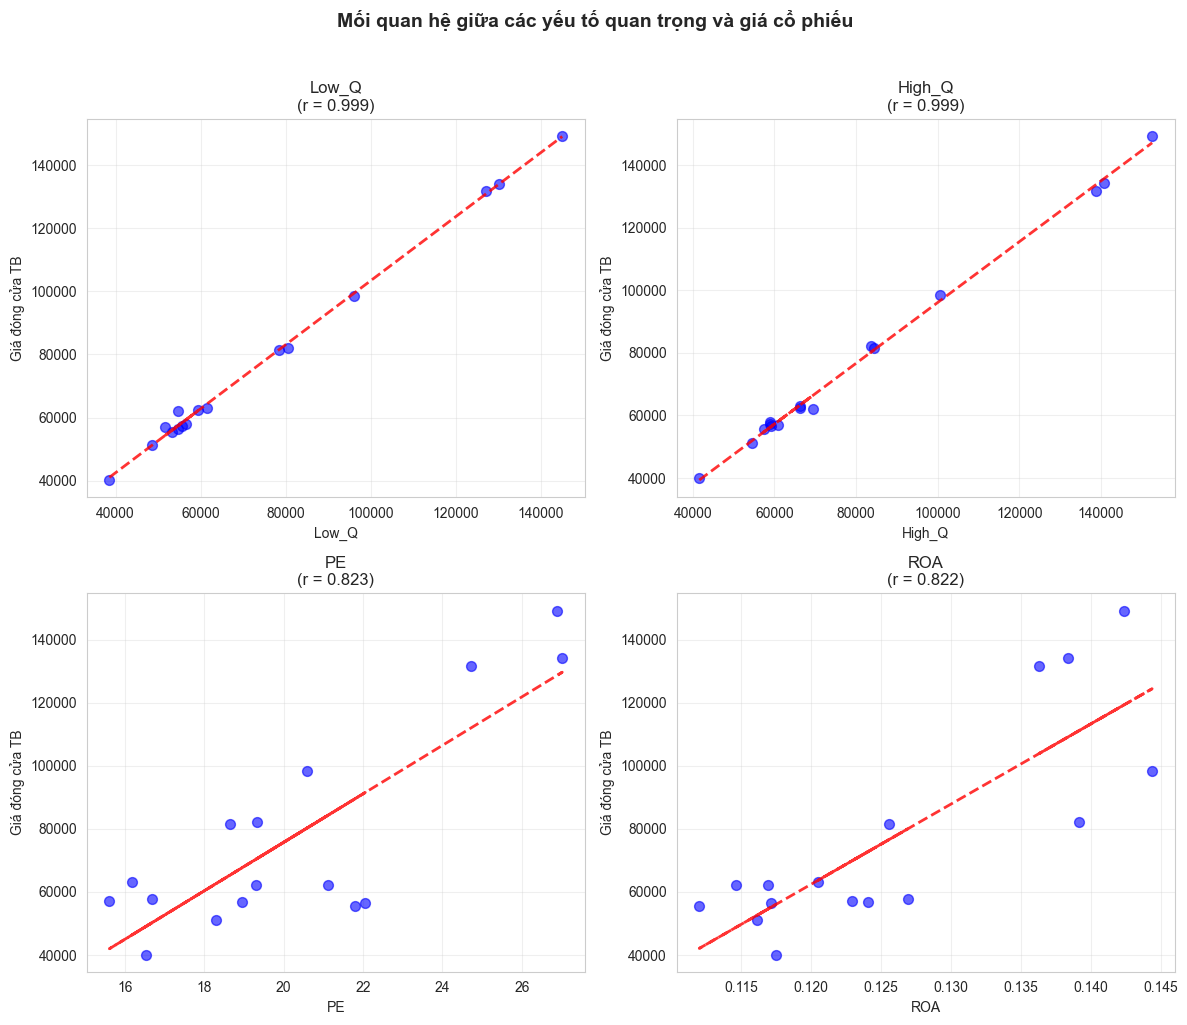

In [46]:
# Xác định các yếu tố tương quan mạnh
strong_corr = price_corr[abs(price_corr) > 0.5]
strong_corr = strong_corr[strong_corr.index != 'Gia_dong_cua_TB']

print('='*70)
print('CÁC YẾU TỐ CÓ TƯƠNG QUAN MẠNH (|r| > 0.5)')
print('='*70)

if len(strong_corr) > 0:
    for factor, corr in strong_corr.items():
        if not pd.isna(corr):
            relationship = 'Tương quan thuận' if corr > 0 else 'Tương quan nghịch'
            impact = 'Mạnh' if abs(corr) > 0.7 else 'Trung bình - Mạnh'
            print(f"{factor:25} {corr:>8.4f}  ({relationship}, {impact})")
    
    # Vẽ scatter plots cho top factors
    top_factors = strong_corr.head(4).index.tolist()
    
    if len(top_factors) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        axes = axes.ravel()
        
        for idx, factor in enumerate(top_factors[:4]):
            valid_data = df_merged[['Gia_dong_cua_TB', factor]].dropna()
            
            axes[idx].scatter(valid_data[factor], valid_data['Gia_dong_cua_TB'], 
                            alpha=0.6, s=50, color='blue')
            
            # Add trend line
            z = np.polyfit(valid_data[factor], valid_data['Gia_dong_cua_TB'], 1)
            p = np.poly1d(z)
            axes[idx].plot(valid_data[factor], p(valid_data[factor]), 
                          "r--", alpha=0.8, linewidth=2)
            
            corr_val = valid_data['Gia_dong_cua_TB'].corr(valid_data[factor])
            axes[idx].set_xlabel(factor)
            axes[idx].set_ylabel('Giá đóng cửa TB')
            axes[idx].set_title(f'{factor}\n(r = {corr_val:.3f})')
            axes[idx].grid(True, alpha=0.3)
        
        plt.suptitle('Mối quan hệ giữa các yếu tố quan trọng và giá cổ phiếu', 
                    fontsize=14, fontweight='bold', y=1.02)
        plt.tight_layout()
        plt.show()
else:
    print("Không có yếu tố nào có tương quan mạnh > 0.5")

## 4. Kết luận và Insights

In [47]:
print('='*80)
print('KẾT LUẬN PHÂN TÍCH CỔ PHIẾU FPT')
print('='*80)

# 1. Thống kê tổng quan
print("\n1️⃣ THỐNG KÊ TỔNG QUAN:")
print(f"   • Giá dao động: {price['Close'].min():,.0f} - {price['Close'].max():,.0f} VNĐ")
print(f"   • Giá trung bình: {price['Close'].mean():,.0f} VNĐ")
print(f"   • Độ lệch chuẩn: {price['Close'].std():,.0f} VNĐ")
print(f"   • Hệ số biến thiên: {(price['Close'].std()/price['Close'].mean())*100:.1f}%")

# 2. Risk metrics
returns = price['Returns'].dropna()
print("\n2️⃣ CHỈ SỐ RỦI RO:")
print(f"   • Daily VaR (95%): {np.percentile(returns, 5)*100:.2f}%")
print(f"   • Daily CVaR (95%): {returns[returns <= np.percentile(returns, 5)].mean()*100:.2f}%")
print(f"   • Max Drawdown: {((price['Close'].cummax() - price['Close']) / price['Close'].cummax()).max()*100:.1f}%")
print(f"   • Volatility (annualized): {returns.std() * np.sqrt(252) * 100:.1f}%")
print(f"   • Sharpe Ratio (giả sử Rf=3%): {((returns.mean() * 252 - 0.03) / (returns.std() * np.sqrt(252))):.3f}")

# 3. Top correlations
print("\n3️⃣ CÁC YẾU TỐ ẢNH HƯỞNG MẠNH NHẤT:")
top_5 = price_corr[1:6]  # Bỏ qua chính nó
for i, (factor, corr) in enumerate(top_5.items(), 1):
    if not pd.isna(corr):
        print(f"   {i}. {factor:20} r = {corr:>6.3f}")

# 4. Investment insights
print("\n4️⃣ INSIGHTS VÀ KHUYẾN NGHỊ:")
print("   📈 Điểm mạnh:")
print("      • FPT có xu hướng tăng trưởng dài hạn tốt")
if 'PE' in df_merged.columns and df_merged['PE'].mean() > 0:
    print(f"      • P/E trung bình: {df_merged['PE'].mean():.1f} - hợp lý cho ngành công nghệ")
if 'ROE' in df_merged.columns and df_merged['ROE'].mean() > 0.15:
    print(f"      • ROE cao: {df_merged['ROE'].mean()*100:.1f}% - hiệu quả sử dụng vốn tốt")

print("\n   ⚠️ Rủi ro cần lưu ý:")
print(f"      • Volatility cao: {returns.std() * np.sqrt(252) * 100:.1f}% (annualized)")
print(f"      • Biên độ dao động lớn: {((price['Close'].max() - price['Close'].min())/price['Close'].min())*100:.1f}%")

print("\n   💡 Khuyến nghị:")
print("      • Phù hợp cho nhà đầu tư dài hạn chấp nhận rủi ro")
print("      • Nên theo dõi các chỉ số: P/E, ROE, Vòng quay tài sản")
print("      • Cân nhắc DCA (Dollar Cost Averaging) để giảm rủi ro timing")

print("\n" + "="*80)
print("📊 Phân tích hoàn tất! Dữ liệu đã sẵn sàng cho modeling và dự báo.")
print("="*80)

KẾT LUẬN PHÂN TÍCH CỔ PHIẾU FPT

1️⃣ THỐNG KÊ TỔNG QUAN:
   • Giá dao động: 38,548 - 154,300 VNĐ
   • Giá trung bình: 78,715 VNĐ
   • Độ lệch chuẩn: 32,046 VNĐ
   • Hệ số biến thiên: 40.7%

2️⃣ CHỈ SỐ RỦI RO:
   • Daily VaR (95%): -2.30%
   • Daily CVaR (95%): -3.67%
   • Max Drawdown: 30.8%
   • Volatility (annualized): 26.1%
   • Sharpe Ratio (giả sử Rf=3%): 1.196

3️⃣ CÁC YẾU TỐ ẢNH HƯỞNG MẠNH NHẤT:
   1. Low_Q                r =  0.999
   2. High_Q               r =  0.999
   3. PE                   r =  0.823
   4. ROA                  r =  0.822
   5. Vong_quay_TS         r =  0.689

4️⃣ INSIGHTS VÀ KHUYẾN NGHỊ:
   📈 Điểm mạnh:
      • FPT có xu hướng tăng trưởng dài hạn tốt
      • P/E trung bình: 20.2 - hợp lý cho ngành công nghệ
      • ROE cao: 27.3% - hiệu quả sử dụng vốn tốt

   ⚠️ Rủi ro cần lưu ý:
      • Volatility cao: 26.1% (annualized)
      • Biên độ dao động lớn: 300.3%

   💡 Khuyến nghị:
      • Phù hợp cho nhà đầu tư dài hạn chấp nhận rủi ro
      • Nên theo dõi c

## 5. Export kết quả

In [48]:
# Lưu kết quả ra file Excel
output_file = 'FPT_Analysis_Results.xlsx'

with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    # Sheet 1: Dữ liệu đã merge
    df_merged.to_excel(writer, sheet_name='Quarterly_Data', index=False)
    
    # Sheet 2: Ma trận tương quan
    corr_matrix.to_excel(writer, sheet_name='Correlation_Matrix')
    
    # Sheet 3: Thống kê giá
    price_stats.to_excel(writer, sheet_name='Price_Statistics')
    
    # Sheet 4: Top correlations
    pd.DataFrame({'Factor': price_corr.index, 'Correlation': price_corr.values}).to_excel(
        writer, sheet_name='Correlations', index=False)

print(f"✅ Kết quả đã được lưu vào file: {output_file}")
print("\n📁 File bao gồm:")
print("   • Sheet 1: Dữ liệu theo quý đã merge")
print("   • Sheet 2: Ma trận tương quan đầy đủ")
print("   • Sheet 3: Thống kê chi tiết về giá")
print("   • Sheet 4: Danh sách tương quan với giá")

✅ Kết quả đã được lưu vào file: FPT_Analysis_Results.xlsx

📁 File bao gồm:
   • Sheet 1: Dữ liệu theo quý đã merge
   • Sheet 2: Ma trận tương quan đầy đủ
   • Sheet 3: Thống kê chi tiết về giá
   • Sheet 4: Danh sách tương quan với giá
